In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Electricity Supply Dataset (Photovoltaik)

In [2]:
# Import Supply Dataset

sData = pd.read_csv('../Seminar_2024_Data/Realised_Supply_Germany.csv', sep=';', 
                   decimal=',', thousands='.', usecols=[0,1,6], dtype={'Date from': object, 'Date to': object})

# casting Year column to datetime object
sData['Date from'] = pd.to_datetime(sData['Date from'], format="%d.%m.%y %H:%M", dayfirst=True) 

# Create new date range as index with frequency (to clean up time shifts)
date_rng = pd.date_range(start='2019-01-01 00:00', end='2022-12-31 23:45', freq='15min')

# Setting index 
sData = sData.set_index(date_rng)

# Drop Date columns
sData = sData.drop(columns=['Date to', 'Date from'])

# Aggregate Rows into 1 hour steps
sData = sData.resample('h').mean()

# set the recording frequency of the data
sData = sData.asfreq('h')

# Split Dataset
#train_data, test_data = sData[:"2021-12-31 23:00:00"].copy(), sData["2022-01-01 00:00:00":].copy()
# The last month of 21 is for validating (744 hours)
train_data, test_data = sData[:"2021-11-30 23:00:00"].copy(), sData["2021-12-01 00:00:00":].copy()

# standardize data
scaler_supply = StandardScaler()
train_data["Photovoltaic [MW]"] = scaler_supply.fit_transform(train_data["Photovoltaic [MW]"].values.reshape(-1,1))
test_data["Photovoltaic [MW]"] = scaler_supply.transform(test_data["Photovoltaic [MW]"].values.reshape(-1,1))

#sData.plot() # We see there is a trend in the data -> should be represented as a trend component


# Weather Dataset

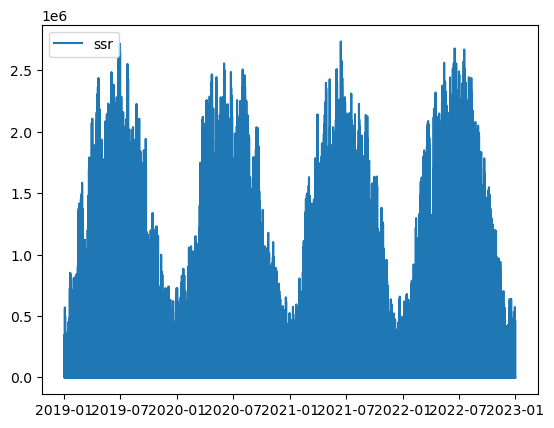

In [3]:
# Import Wheater Dataset
wData = pd.read_csv('../Seminar_2024_Data/Weather_Data_Germany.csv', sep=',', 
                   decimal='.', usecols=['time', 'ssr'])

wData22 = pd.read_csv('../Seminar_2024_Data/Weather_Data_Germany_2022.csv', sep=',', 
                   decimal='.', usecols=['time', 'ssr'])

# Merge the 2 datasets
wData = pd.concat([wData, wData22]) 

# casting Year column to datetime object
wData['time'] = pd.to_datetime(wData['time']) 

# aggregating rows by time, taking mean of the values

wData = wData.groupby('time', as_index=False, sort=False).mean()

# alternative use every 80th row
#wData = wData.iloc[0::80]

# Calculating the momentary ssr value from the cumulated values
wData["ssr normal"] = wData["ssr"] - wData["ssr"].shift(1, fill_value=0) 

# For every 24th row, set the normal value to be the cumulative value
wData.loc[(wData.index) % 24 == 0, 'ssr normal'] = wData['ssr']

# Setting Year as index 
wData = wData.set_index('time')

# set the recording frequency of the Data
wData = wData.asfreq('h')

wData = wData.drop(columns=["ssr"])

# Split Dataset (the last month of 21 is for validation)
train_data_w, test_data_w = wData[:"2021-11-30 23:00:00"], wData["2021-12-01 00:00:00":]

# standardize data
scaler_weather = StandardScaler()
train_data_w = scaler_weather.fit_transform(train_data_w.values.reshape(-1,1))
test_data_w = scaler_weather.transform(test_data_w.values.reshape(-1,1))

plt.plot(wData["ssr normal"], label = "ssr")
# plt.plot(sData["Photovoltaic [MW]"], label = "Photovoltaic [MW]")
plt.legend()
# start_date = pd.Timestamp('2020-01-01')
# end_date = pd.Timestamp('2020-01-15')
# plt.xlim(start_date, end_date)


# Applying the model

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

#FORECAST_RANGE =  100 #744 - 1
FORECAST_RANGE = 8760 + 744 - 1

In [ ]:

# Model definition
model_order = (3,0,0) # (3,0,0)

# First prediction after end of test_set
model = SARIMAX(train_data, order=model_order, exog=train_data_w)

model_fit = model.fit(disp=False)

predictions = []
# Forecast step by step
for i in range(FORECAST_RANGE):
    # Forecast one step then add observed value to model
    yhat = model_fit.forecast(exog=test_data_w[i:i+1]).iloc[0]
    predictions.append(yhat)
    model_fit = model_fit.append(test_data[i:i+1], refit=False, exog=test_data_w[i:i+1])

print(model_fit.summary())

# Apply Inverse transform
predictions = pd.DataFrame(predictions)
predictions = scaler_supply.inverse_transform(predictions.values.reshape(1,-1)).flatten()

predicted_energy_supply = pd.DataFrame(predictions, index=test_data.index[:FORECAST_RANGE])

# Save results
predicted_energy_supply.to_pickle("solar_1h.pkl")


In [ ]:
# Get results from disk
predicted_energy_supply = pd.read_pickle("solar_1h.pkl")
predicted_energy_supply.info()

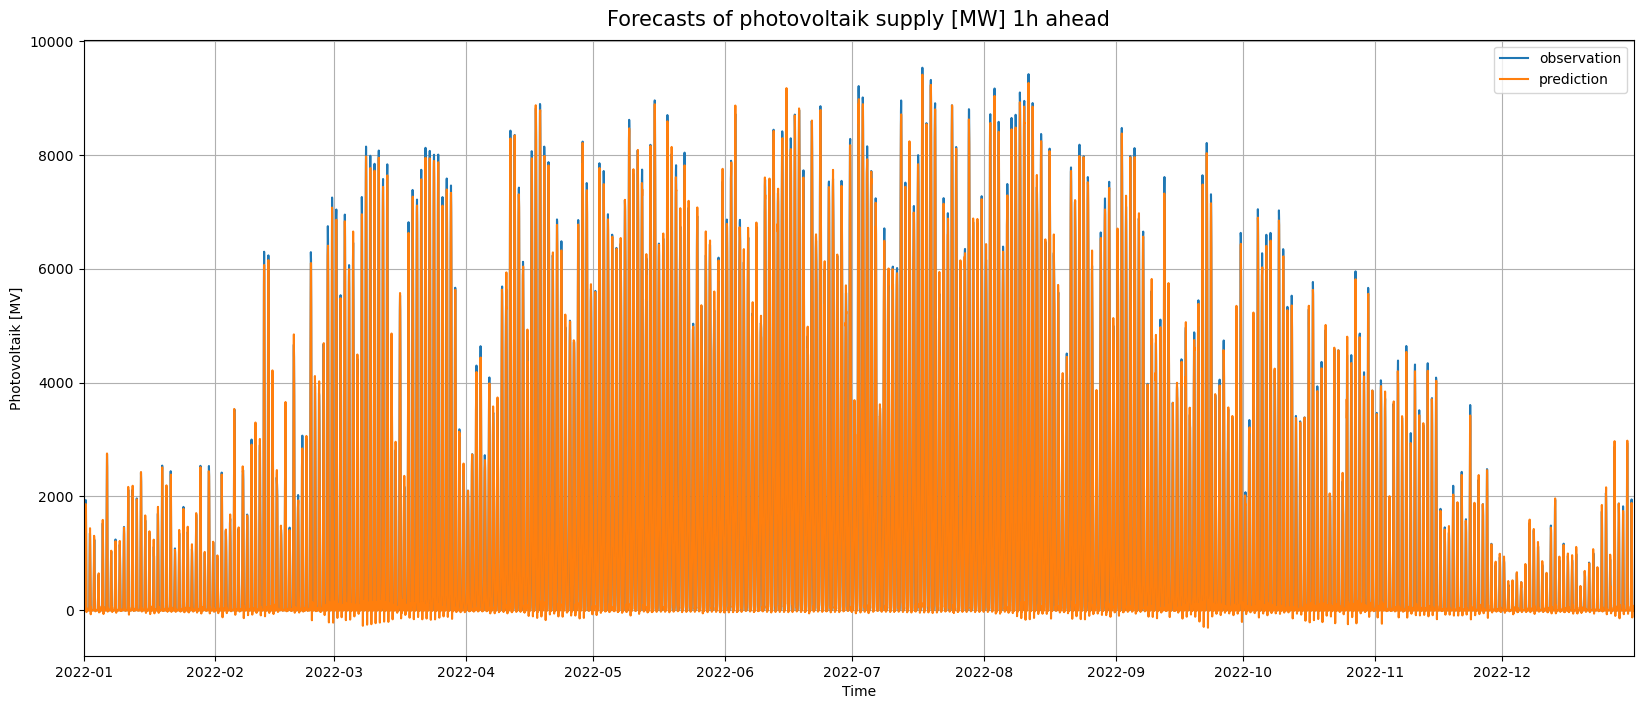

In [6]:
# Construct the set of test target values
y_set = sData["2021-12-01 00:00:00":]

# Overall Plot

plt.figure(figsize=(20,8))
plt.title("Forecasts of photovoltaik supply [MW] 1h ahead", fontsize=15, pad=10)
plt.plot(y_set[:FORECAST_RANGE], label="observation")
plt.plot(predicted_energy_supply, label="prediction")
#plt.plot(wData["ssr normal"]["2021-12-01 00:00:00":"2021-12-31 00:00:00"]/300, label="ssr")
plt.grid()
plt.xlabel('Time')
plt.ylabel('Photovoltaik [MV]')
start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp("2022-12-31 23:45:00")
plt.xlim(start_date, end_date)
plt.legend()

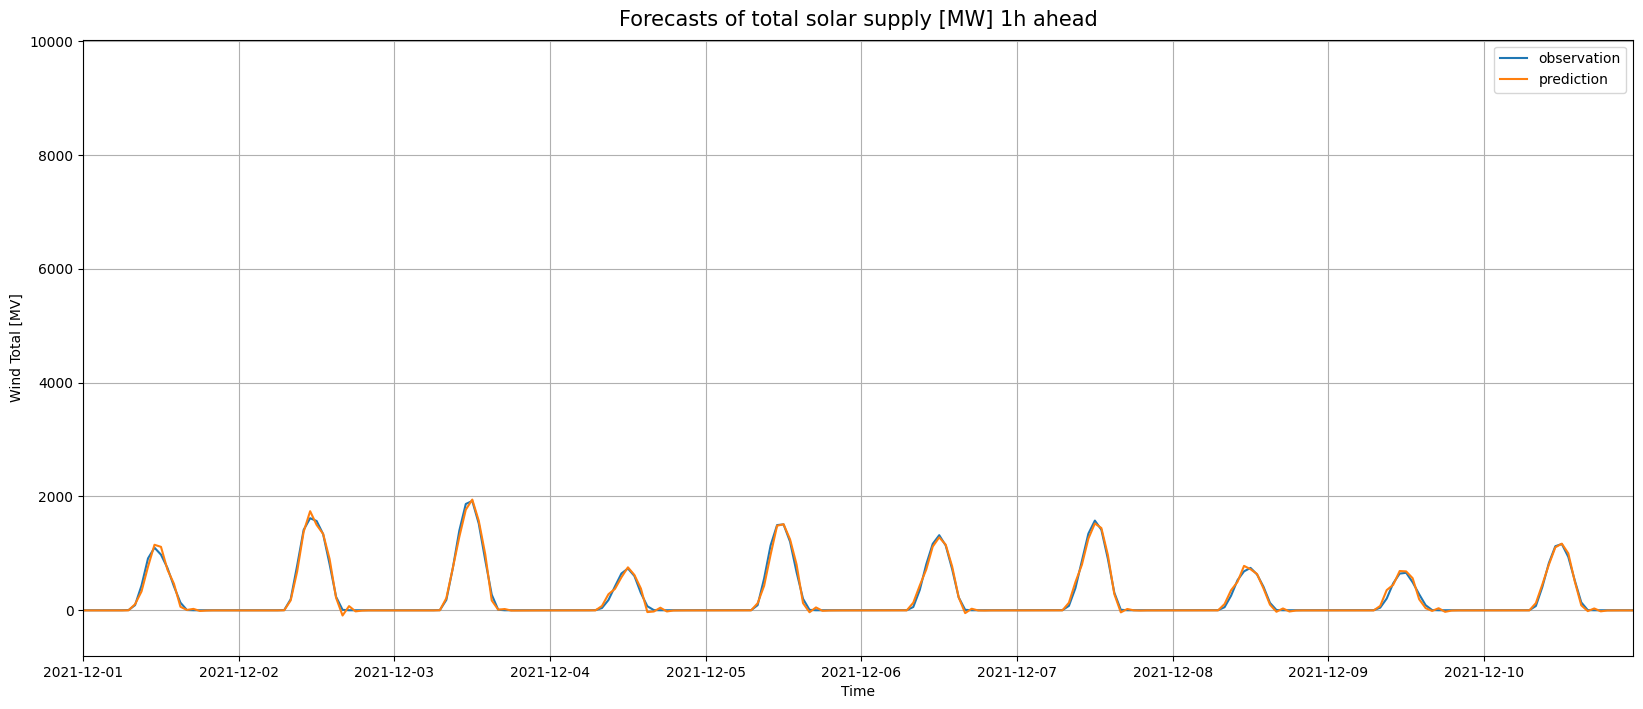

In [8]:
# Detail Plot

plt.figure(figsize=(20,8))
plt.title("Forecasts of total solar supply [MW] 1h ahead", fontsize=15, pad=10)
plt.plot(y_set[:FORECAST_RANGE], label="observation")
plt.plot(predicted_energy_supply, label="prediction")
#plt.plot(wData["ssr normal"]["2021-12-01 00:00:00":"2021-12-31 00:00:00"]/300, label="ssr")
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wind Total [MV]')
start_date = pd.Timestamp('2021-12-01 00:00:00')
end_date = pd.Timestamp("2021-12-10 23:00:00")
plt.xlim(start_date, end_date)
plt.legend()

Evaluation

In [9]:
# report performance
mse = mean_squared_error(y_set["Photovoltaic [MW]"][:FORECAST_RANGE], predicted_energy_supply)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_set["Photovoltaic [MW]"][:FORECAST_RANGE], predicted_energy_supply)
print('MAE: '+str(mae))
rmse = math.sqrt(mse)
print('RMSE: '+str(rmse))

# Get AIC and BIC values
aic = model_fit.aic
bic = model_fit.bic

print(f"AIC: {aic}, BIC: {bic}")

MSE: 13639.578758634923
MAE: 68.91302429455008
RMSE: 116.78860714399724
AIC: -108986.26065977817, BIC: -108943.93615116611



Validating with December 21:

100f
- 3,0,3:
RMSE: 234.2515633347058
AIC: -83954.15950248901, BIC: -83880.78530474548
- 3,0,1:
RMSE: 234.13149225724175
AIC: -83939.23305493983, BIC: -83890.31692311082 


Plotting the results

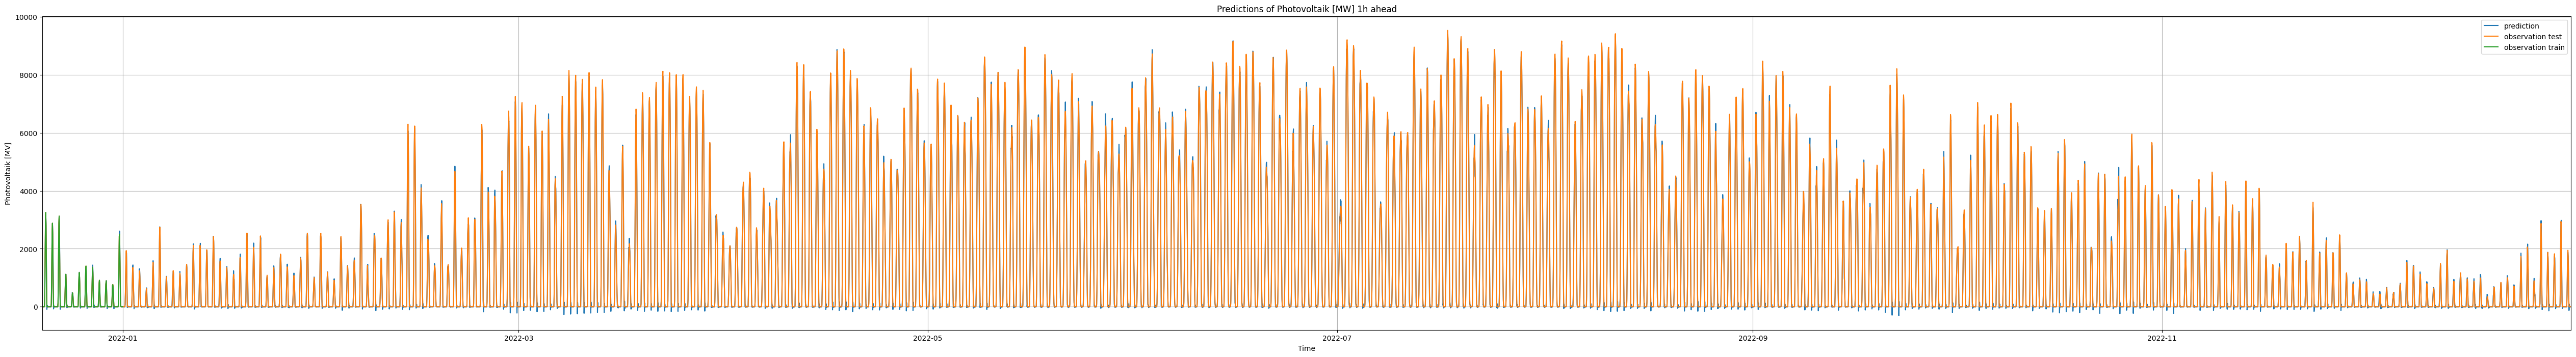

In [10]:
# Big Plot

plt.figure(figsize=(64,8))
plt.title('Predictions of Photovoltaik [MW] 1h ahead')
plt.plot(predicted_energy_supply, label="prediction")
plt.plot(y_set["Photovoltaic [MW]"], label="observation test")
plt.plot(sData[:'2021-12-31 23:00'], label="observation train")
plt.xlabel('Time')
plt.ylabel('Photovoltaik [MV]')
plt.legend()
plt.grid()
start_date = pd.Timestamp('2021-12-20')
end_date = pd.Timestamp("2022-12-31 23:00:00")
plt.xlim(start_date, end_date)
#plt.savefig('photovoltaik_arima010_ssr_normal_as_X_1h.pdf')
plt.show()


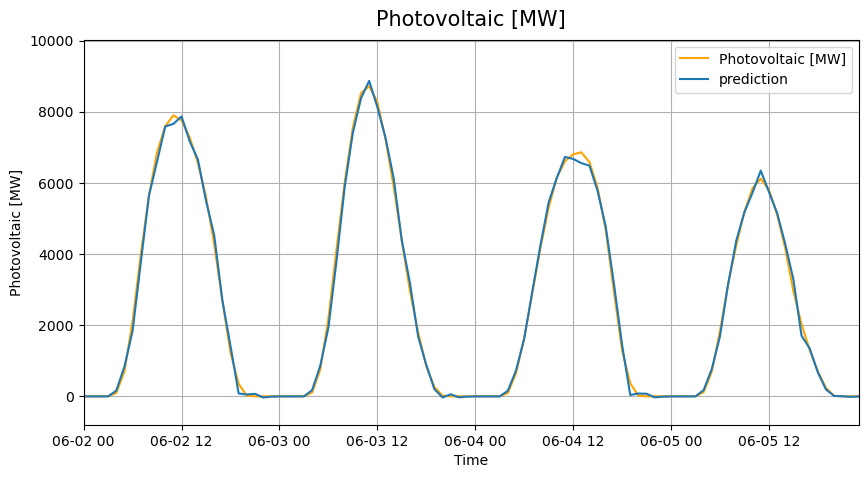

In [18]:
# Detail Plot 2 to show daily seasonality

plt.figure(figsize=(10,5))
plt.title("Photovoltaic [MW]", fontsize=15, pad=10)
plt.plot(y_set[:FORECAST_RANGE], label="Photovoltaic [MW]", color = "orange")
#plt.plot(predicted_energy_supply, label="prediction")
#plt.plot(wData["ssr normal"]["2021-12-01 00:00:00":"2021-12-31 00:00:00"]/300, label="ssr")
plt.grid()
plt.xlabel('Time')
plt.ylabel('Photovoltaic [MW]')
start_date = pd.Timestamp('2022-06-02 00:00:00')
end_date = pd.Timestamp("2022-06-05 23:00:00")
plt.xlim(start_date, end_date)
plt.legend()

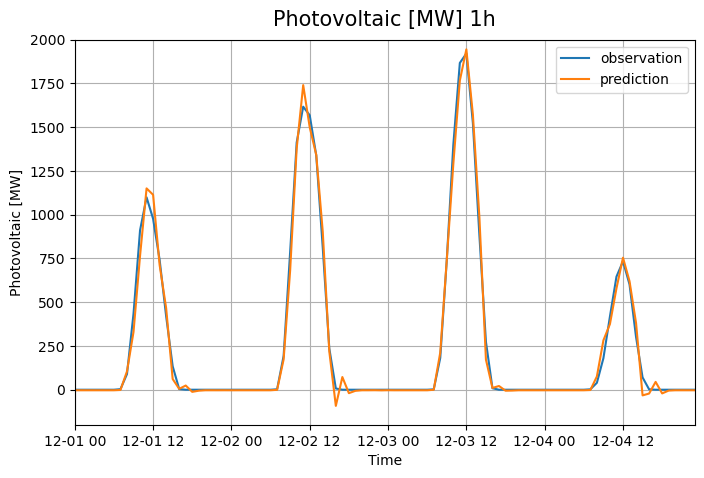

In [28]:
# Detail Plot 2 to show validation set forecast

plt.figure(figsize=(8,5))
plt.title("Photovoltaic [MW] 1h", fontsize=15, pad=10)
plt.plot(y_set[:FORECAST_RANGE], label="observation")
plt.plot(predicted_energy_supply, label="prediction")
#plt.plot(wData["ssr normal"]["2021-12-01 00:00:00":"2021-12-31 00:00:00"]/300, label="ssr")
plt.grid()
plt.xlabel('Time')
plt.ylabel('Photovoltaic [MW]')
start_date = pd.Timestamp('2021-12-01 00:00:00')
end_date = pd.Timestamp("2021-12-04 23:00:00")
plt.xlim(start_date, end_date)
plt.ylim(-200, 2000)
plt.legend()